# Program Header

In [6]:
import pandas as pd
import numpy as np
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from header import *

In [7]:
data_root = initialize_data_root("AY")

In [8]:
import difflib
import jellyfish
import fuzzywuzzy
from fuzzywuzzy import process

# Table of contents
1. [Import](#Import)
2. [Create Tag Map](#CreateTagMap)
5. [Save](#Save)

## Import <a name="Import"></a>

In [9]:
raw_sec_data = pd.read_csv(data_root+'02-build/clean/2019q3/sec_data_long.csv')

## Create Tag Map <a name="CreateTagMap"></a>

In [10]:
sec_data = raw_sec_data.copy()

A good tag has strong reach (at least 90%) and isn't so general as to have too many duplicates. To generate a strong tag, we use fuzzywuzzy to find similar tags and then find the longest substring between them. Then, we evaluate how good of a tag it is. Once a group of tags have been formed, they are removed from the raw tag group, making future operations faster and faster.

In [137]:
def get_tag_reach(list_of_tags):
    search_pattern = '|'.join(list_of_tags)
    total = sec_data['tag'].str.contains(search_pattern)
    return(sum(total)/len(sec_data.adsh.unique()))

In [2]:
def find_contain_matches(test_tag):
    matching_tags = sec_data['tag'].str.contains(test_tag)
    return(sec_data['tag'].loc[matching_tags].unique())

In [59]:
def view_all_tags_for_company(adsh):
    tags = sec_data.loc[sec_data.adsh == adsh].tag.unique()
    return(tags)

In [88]:
def find_fuzzy_matches(tag):
    fuzzy_matches = process.extract(tag, sec_data['tag'].unique())
    return([i[0] for i in fuzzy_matches])

In [22]:
list_of_necessary_tags = ['Revenue', 'Net Income', 'Assets', 'Liabilities', 'Shareholder Equity', 'Operating Cash Flow', 'Depreciation']

Let's create dictionaries of tags starting from the most common:

In [64]:
tag_occurence = sec_data.tag.value_counts()/len(sec_data.adsh.unique())

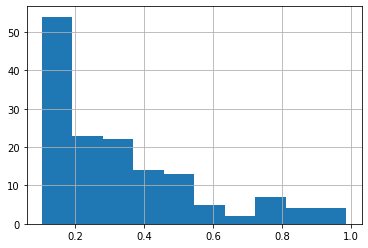

In [74]:
common_tags.hist()

Since the cutoff seems to be at 0.2, let's set the common tags to be above that:

In [114]:
medium_tags = tag_occurence.loc[(tag_occurence > 0.2)&(tag_occurence < 0.7)].index

Let's make dictionaries of tags now:

In [125]:
tag_map = {}

In [126]:
for i in medium_tags:
    matches = find_fuzzy_matches(i)
    tag_map[i] = matches

We'll convert these dictionary tag maps to a data-frame to easily use SQL-style joins.

In [127]:
tag_map_df = pd.DataFrame(columns = ['clean_tag', 'tag'])
tag_map_df

,clean_tag,tag


In [128]:
map_df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in tag_map.items()]))\
            .melt()\
            .dropna()\
            .rename({'variable':'clean_tag', 'value':'tag'}, axis = 'columns')

In [129]:
map_df

,clean_tag,tag
0,IncomeTaxExpenseBenefit,IncomeTaxExpenseBenefit
1,IncomeTaxExpenseBenefit,IncomeTaxExpenseBenefitCity
2,IncomeTaxExpenseBenefit,TaxCutsAndJobsActOf2017IncomeTaxExpenseBenefit
3,IncomeTaxExpenseBenefit,StateAndLocalIncomeTaxExpenseBenefitContinuing...
4,IncomeTaxExpenseBenefit,DeferredFederalIncomeTaxExpenseBenefit
5,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AccumulatedOtherComprehensiveIncomeLossNetOfTax
6,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AccumulatedOtherComprehensiveIncomeLossOtherNe...
7,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AccumulatedOtherComprehensiveIncomeLossTax
8,AccumulatedOtherComprehensiveIncomeLossNetOfTax,AccumulatedOtherComprehensiveIncomeLossBeforeTax1
9,AccumulatedOtherComprehensiveIncomeLossNetOfTax,OtherComprehensiveIncomeLoss


In [154]:
for i,j in tag_map.items():
    print(i,"%.2f %.2f"%(round(get_tag_reach([i]),2), round(get_tag_reach(j),2)))

IncomeTaxExpenseBenefit 0.75 0.75
AccumulatedOtherComprehensiveIncomeLossNetOfTax 0.60 2.71
OperatingLeaseRightOfUseAsset 0.59 0.59
OperatingLeaseLiability 1.94 1.94
AccountsPayableCurrent 0.60 0.67
ComprehensiveIncomeNetOfTax 0.90 0.90
WeightedAverageNumberOfSharesOutstandingBasic 0.54 2.81
PreferredStockSharesAuthorized 0.54 0.54
InterestExpense 1.10 1.27
WeightedAverageNumberOfDilutedSharesOutstanding 0.53 2.49
EarningsPerShareBasic 0.87 0.87
EarningsPerShareDiluted 0.51 0.51
OtherAssetsNoncurrent 0.52 6.58
AccountsReceivableNetCurrent 0.50 0.51
AdditionalPaidInCapital 1.47 1.47
PreferredStockParOrStatedValuePerShare 0.48 0.48
Goodwill 1.10 1.10
CashCashEquivalentsRestrictedCashAndRestrictedCashEquivalents 0.66 0.66
OperatingLeaseLiabilityCurrent 0.46 0.92
OperatingLeaseLiabilityNoncurrent 0.46 0.92
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest 0.45 1.08
OperatingExpenses 0.47 0.52
AccumulatedDepreciationDepletionAndAmortizationPropertyP

In [139]:
get_tag_reach(tag_map.items()[0])

TypeError: 'dict_items' object is not subscriptable

In [131]:
tag_map

{'IncomeTaxExpenseBenefit': ['IncomeTaxExpenseBenefit',
  'IncomeTaxExpenseBenefitCity',
  'TaxCutsAndJobsActOf2017IncomeTaxExpenseBenefit',
  'StateAndLocalIncomeTaxExpenseBenefitContinuingOperations',
  'DeferredFederalIncomeTaxExpenseBenefit'],
 'AccumulatedOtherComprehensiveIncomeLossNetOfTax': ['AccumulatedOtherComprehensiveIncomeLossNetOfTax',
  'AccumulatedOtherComprehensiveIncomeLossOtherNetofTax',
  'AccumulatedOtherComprehensiveIncomeLossTax',
  'AccumulatedOtherComprehensiveIncomeLossBeforeTax1',
  'OtherComprehensiveIncomeLoss'],
 'OperatingLeaseRightOfUseAsset': ['OperatingLeaseRightOfUseAsset',
  'OperatingLeaseRightOfUseAssets',
  'OperatingLeaseRightOfUseAssetNet',
  'OperatingLeaseRightofUseAssetNet',
  'OperatingSubleaseRightOfUseAsset'],
 'OperatingLeaseLiability': ['OperatingLeaseLiability',
  'OperatingLeaseLiability1',
  'OpeartingLeaseLiability',
  'OperatingLeaseLiabilities',
  'LesseeOperatingLeaseLiabilityPaymentsDue'],
 'AccountsPayableCurrent': ['AccountsPay

In [17]:
print("Consolidated ",round((1-len(tag_map_df.clean_tag.unique())/len(tag_map_df.tag.unique()))*100,2),"% of tags", sep = "")

Consolidated 78.11% of tags


In addition to the algorithm, we use domain knowledge to add in exceptions.

## Save <a name="Save"></a>
Save tag map to build/clean

In [20]:
# Save
tag_map_df.to_csv(data_root+'02-build/clean/2019q3/tag_map.csv', index = False)